# 01 - Exploratory Data Analysis ( EDA - WineQT) 

Este notebook carrega o dataset WineQT do Hugging Face, faz uma inspeção inicial e mostra estatísticas descritivas, distribuições e correlações.




In [3]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add the project root to Python path to import from src
sys.path.append(str(Path.cwd().parent))

from src.data_ingestion import load_wine_dataframe

# Config
HF_REPO = os.getenv("HF_DATASET_REPO", "henriquebap/wine-ml-dataset")
FILENAME = os.getenv("HF_DATASET_FILENAME", "WineQT.csv")

# Load
df = load_wine_dataframe(repo_id=HF_REPO, filename=FILENAME)
df.head()


WineQT.csv: 0.00B [00:00, ?B/s]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
df.tail(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1133,6.7,0.320,0.44,2.4,0.061,24.0,34.0,0.99484,3.29,0.80,11.6,7
1134,7.5,0.310,0.41,2.4,0.065,34.0,60.0,0.99492,3.34,0.85,11.4,6
1135,5.8,0.610,0.11,1.8,0.066,18.0,28.0,0.99483,3.55,0.66,10.9,6
1136,6.3,0.550,0.15,1.8,0.077,26.0,35.0,0.99314,3.32,0.82,11.6,6
1137,5.4,0.740,0.09,1.7,0.089,16.0,26.0,0.99402,3.67,0.56,11.6,6
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1142,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
# Info and describe
print(df.shape)
df.info()
df.describe().T


(1143, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


## ANÁLISE PARA ESCOLHA DO PROBLEMA

---

### Definição do Objetivo

Com base na distribuição da variável target **quality** (min=3, max=8, média=5.66), definimos nosso problema de machine learning:

#### 🎯 **CLASSIFICAÇÃO DE QUALIDADE DE VINHOS**

**Objetivo:** Agrupar vinhos em categorias de qualidade baseadas nas características físico-químicas.

**Proposta de Classes:**
- **Baixa qualidade:** 3-4 (vinhos de qualidade inferior)
- **Média qualidade:** 5-6 (vinhos de qualidade padrão)  
- **Alta qualidade:** 7-8 (vinhos de qualidade superior)

**Justificativa:**
- Mais interpretável para o negócio
- Facilita tomada de decisão na produção
- Permite estratégias diferenciadas por categoria

**Métricas de Avaliação:**
- Accuracy (precisão geral)
- F1-score (balanceamento entre precisão e recall)
- Confusion Matrix (análise detalhada por classe)

In [5]:
# Missing values and duplicates
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing>0])

num_dupes = df.duplicated().sum()
print(f"Duplicatas: {num_dupes}")


Series([], dtype: int64)
Duplicatas: 125


Podemos ver que temos 125 items duplicados. Vamos dropar as linhas duplicadas para nao atrapalhar o nosso processo
- A decisao de dropas as linhas foi tomada pelo tamanho da sample duplicada 12 de 1143 é um numero nao representativo

In [ ]:
# drop duplicates
df = df.drop_duplicates()


In [7]:
num_dupes = df.duplicated().sum()
print(f"Duplicatas: {num_dupes}")

Duplicatas: 0


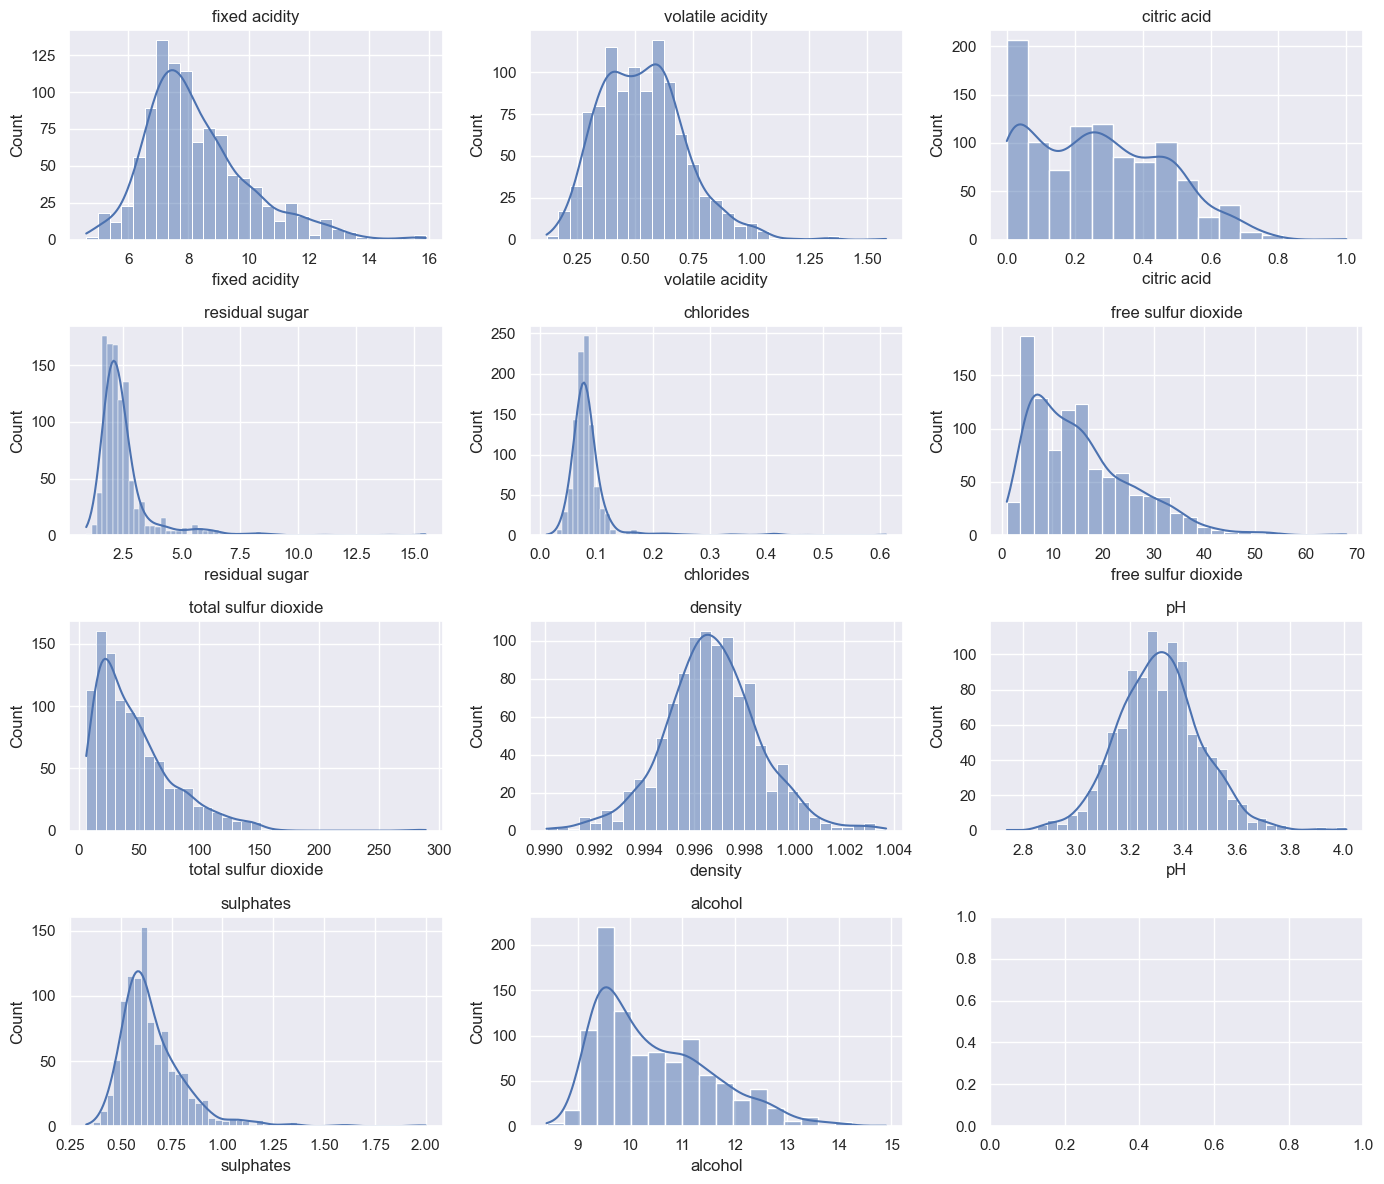

In [8]:
# Distributions
sns.set_theme()
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))
axes = axes.flatten()
for i, col in enumerate([c for c in df.columns if c != 'quality']):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


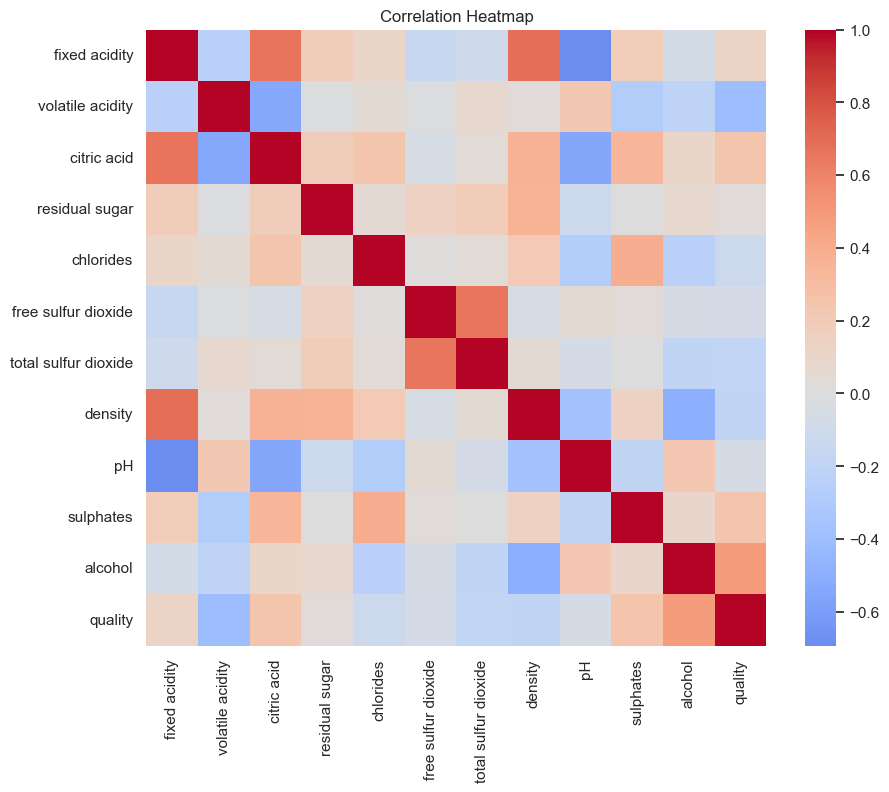

In [9]:
# Correlations
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


Distribuição da variável 'quality':
quality
3      6
4     33
5    433
6    409
7    122
8     15
Name: count, dtype: int64

Estatísticas da qualidade:
Média: 5.64
Mediana: 6.00
Desvio padrão: 0.81
Min: 3, Max: 8


Text(0, 0.5, 'Frequency')

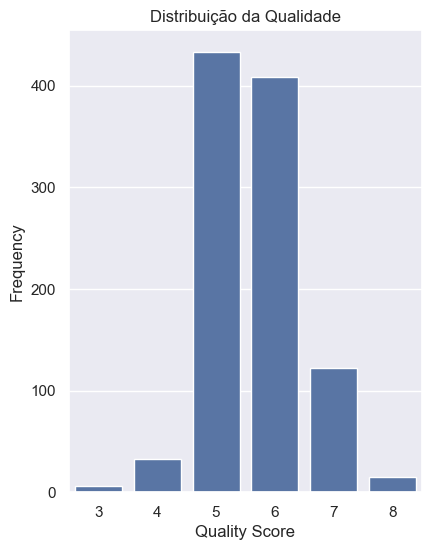

In [15]:
# Contexto do alvo - Análise da distribuição de qualidade
print("Distribuição da variável 'quality':")
print(df['quality'].value_counts().sort_index())
print("\nEstatísticas da qualidade:")
print(f"Média: {df['quality'].mean():.2f}")
print(f"Mediana: {df['quality'].median():.2f}")
print(f"Desvio padrão: {df['quality'].std():.2f}")
print(f"Min: {df['quality'].min()}, Max: {df['quality'].max()}")

# Visualização da distribuição
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='quality')
plt.title('Distribuição da Qualidade')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')



3. DISTRIBUIÇÃO POR CLASSES PROPOSTAS:
quality_class
Média (5-6)    842
Alta (7-8)     137
Baixa (3-4)     39
Name: count, dtype: int64

Percentuais:
   Média (5-6): 82.7%
   Alta (7-8): 13.5%
   Baixa (3-4): 3.8%


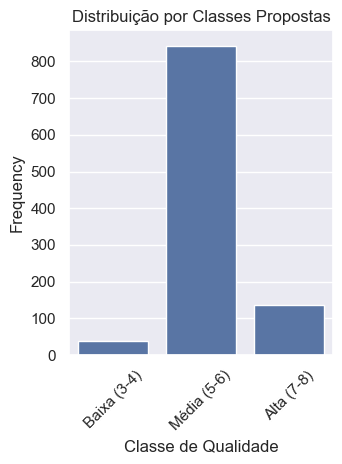

In [14]:



# Verificar distribuição por classes propostas
df_temp = df.copy()
df_temp['quality_class'] = df_temp['quality'].apply(
    lambda x: 'Baixa (3-4)' if x <= 4 else 'Média (5-6)' if x <= 6 else 'Alta (7-8)'
)

print("\n3. DISTRIBUIÇÃO POR CLASSES PROPOSTAS:")
class_counts = df_temp['quality_class'].value_counts()
print(class_counts)
print("\nPercentuais:")
for cls, count in class_counts.items():
    print(f"   {cls}: {count/len(df_temp)*100:.1f}%")

plt.subplot(1, 2, 2)
sns.countplot(data=df_temp, x='quality_class', order=['Baixa (3-4)', 'Média (5-6)', 'Alta (7-8)'])
plt.title('Distribuição por Classes Propostas')
plt.xlabel('Classe de Qualidade')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()